<a href="https://colab.research.google.com/github/o-rma/ML-FLASK-Pythonanywhere/blob/master/%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -y install fonts-ipafont-gothic
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:


import matplotlib.font_manager as fm

# すべての TTF フォントの中から日本語フォントっぽい名前を表示
font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')

print("=== 利用可能な日本語フォント名 ===")
for path in font_paths:
    try:
        font = fm.FontProperties(fname=path)
        name = font.get_name()
        if "IPA" in name or "Gothic" in name or "Noto" in name or "Hiragino" in name or "Yu" in name:
            print(name)
    except Exception:
        continue


=== 利用可能な日本語フォント名 ===
IPAGothic
IPAPGothic
IPAGothic
IPAPMincho
IPAMincho
IPAMincho


In [ ]:
import matplotlib.font_manager as fm

# 使用したいフォント名に合わせて filter
target_font_name = "IPAGothic"  # ご自身の環境で見つかった名前に変更
font_path = None

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    try:
        if fm.FontProperties(fname=font).get_name() == target_font_name:
            font_path = font
            break
    except Exception:
        continue

print("使用するフォントパス:", font_path)


使用するフォントパス: /usr/share/fonts/opentype/ipafont-gothic/ipag.ttf


In [ ]:
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from google.colab import drive, files
import shutil
import os

# 1. Google Drive をマウント
drive.mount('/content/drive')

# データフォルダ内のすべてのExcelファイルを読み込む
file_paths = glob.glob("/content/drive/MyDrive/気象データと熱中症件数まとめ/*.xlsx")  # パスはあなたの環境に合わせて変更

data_list = []

for path in file_paths:
    try:
        df = pd.read_excel(path, sheet_name="Sheet1")  # シート名が統一されている前提
        df["都道府県"] = path.split("/")[-1].replace(".xlsx", "")  # ファイル名から都道府県を取得
        data_list.append(df)
    except Exception as e:
        print(f"{path} の読み込みでエラー: {e}")

# 全ファイル分のデータを結合
all_data = pd.concat(data_list, ignore_index=True)

# 数値変換（エラーは NaN に）
all_data["平均気温"] = pd.to_numeric(all_data["平均気温"], errors="coerce")
all_data["平均湿度"] = pd.to_numeric(all_data["平均湿度"], errors="coerce")
all_data["件数"] = pd.to_numeric(all_data["件数"], errors="coerce")

# 欠損値の除去
df_clean = all_data.dropna(subset=["平均気温", "平均湿度", "件数"])

# 重回帰分析（全国データで）
X = df_clean[["平均気温", "平均湿度"]]
y = df_clean["件数"]

model = LinearRegression()
model.fit(X, y)

# 結果の出力
coef = model.coef_
intercept = model.intercept_

print("=== 全国47都道府県のデータを使った重回帰分析結果 ===")
print(f"回帰係数: 平均気温 = {coef[0]:.2f}, 平均湿度 = {coef[1]:.2f}")
print(f"切片: {intercept:.2f}")
print(f"重回帰式: 熱中症件数 = {coef[0]:.2f} * 平均気温 + {coef[1]:.2f} * 平均湿度 + {intercept:.2f}")
r2 = model.score(X, y)
print(f"決定係数 R²: {r2:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== 全国47都道府県のデータを使った重回帰分析結果 ===
回帰係数: 平均気温 = 2.65, 平均湿度 = -0.11
切片: -47.70
重回帰式: 熱中症件数 = 2.65 * 平均気温 + -0.11 * 平均湿度 + -47.70
決定係数 R²: 0.2068


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


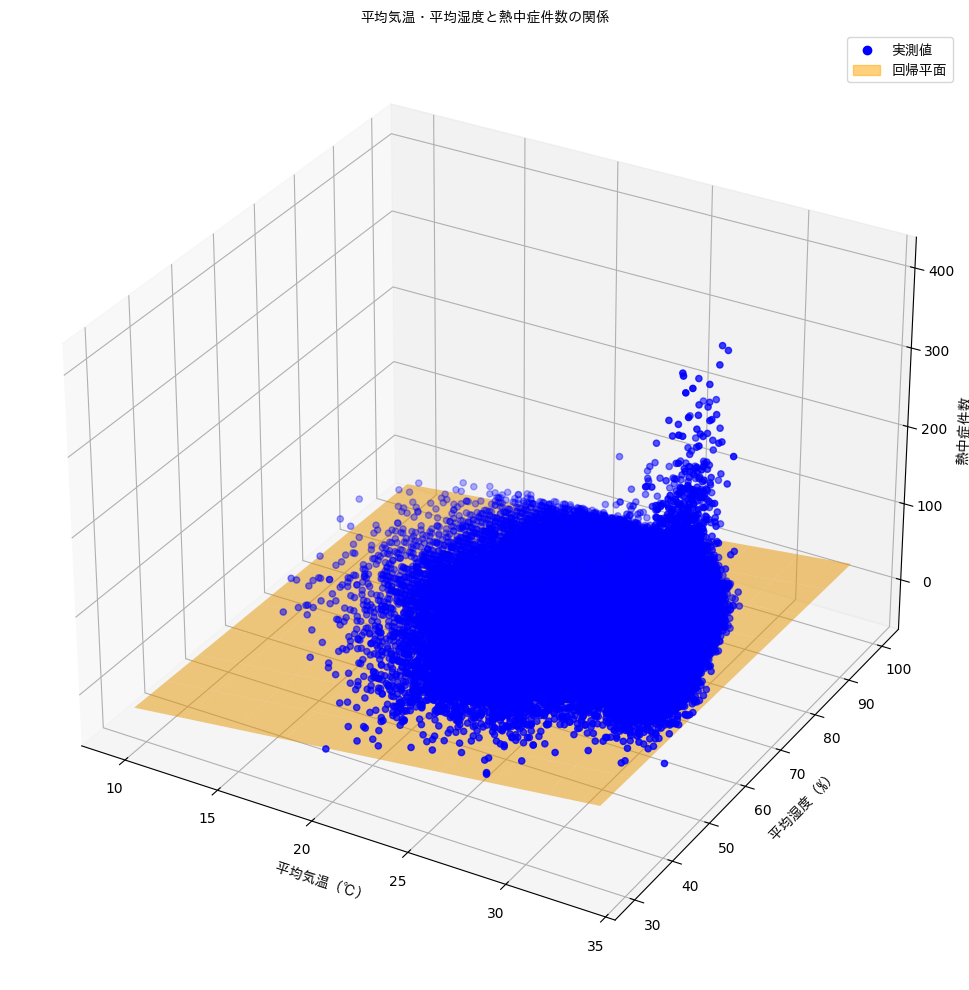

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np

jp_font = fm.FontProperties(fname=font_path)

# 説明変数
x_temp = df_clean["平均気温"]
x_humi = df_clean["平均湿度"]
y_count = df_clean["件数"]


# 回帰平面用の格子データ
temp_range = np.linspace(x_temp.min(), x_temp.max(), 10)
humi_range = np.linspace(x_humi.min(), x_humi.max(), 10)
temp_grid, humi_grid = np.meshgrid(temp_range, humi_range)
count_pred = model.predict(np.c_[temp_grid.ravel(), humi_grid.ravel()]).reshape(temp_grid.shape)

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 散布図
scatter_plot = ax.scatter(x_temp, x_humi, y_count, color='blue')

# 回帰平面
surface_plot = ax.plot_surface(temp_grid, humi_grid, count_pred, color='orange', alpha=0.5)

# ラベル
ax.set_xlabel("平均気温 (℃)", fontproperties=jp_font)
ax.set_ylabel("平均湿度 (%)", fontproperties=jp_font)
ax.set_zlabel("熱中症件数", fontproperties=jp_font)
ax.set_title("平均気温・平均湿度と熱中症件数の関係", fontproperties=jp_font)

# 凡例を手動で作成
scatter_proxy = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='実測値')
surface_proxy = mpatches.Patch(color='orange', alpha=0.5, label='回帰平面')
ax.legend(handles=[scatter_proxy, surface_proxy],prop=fontproperties)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from google.colab import drive, files
import shutil
import os

# 1. Google Drive をマウント
drive.mount('/content/drive')
# データフォルダ内のすべてのExcelファイルを読み込む
file_paths = glob.glob("/content/drive/MyDrive/気象データと熱中症件数まとめ/*.xlsx")  # パスはあなたの環境に合わせて変更

data_list = []

for path in file_paths:
    try:
        df = pd.read_excel(path, sheet_name="Sheet1")  # シート名が統一されている前提
        df["都道府県"] = path.split("/")[-1].replace(".xlsx", "")  # ファイル名から都道府県を取得
        data_list.append(df)
    except Exception as e:
        print(f"{path} の読み込みでエラー: {e}")

# 全ファイル分のデータを結合
all_data = pd.concat(data_list, ignore_index=True)

# 数値変換（エラーは NaN に）
all_data["最高気温"] = pd.to_numeric(all_data["最高気温"], errors="coerce")
all_data["平均湿度"] = pd.to_numeric(all_data["平均湿度"], errors="coerce")
all_data["件数"] = pd.to_numeric(all_data["件数"], errors="coerce")

# 欠損値の除去
df_clean = all_data.dropna(subset=["最高気温", "平均湿度", "件数"])

# 重回帰分析（全国データで）
X = df_clean[["最高気温", "平均湿度"]]
y = df_clean["件数"]

model = LinearRegression()
model.fit(X, y)

# 結果の出力
coef = model.coef_
intercept = model.intercept_

print("=== 全国47都道府県のデータを使った重回帰分析結果 ===")
print(f"回帰係数: 最高気温 = {coef[0]:.2f}, 平均湿度 = {coef[1]:.2f}")
print(f"切片: {intercept:.2f}")
print(f"重回帰式: 熱中症件数 = {coef[0]:.2f} * 最高気温 + {coef[1]:.2f} * 平均湿度 + {intercept:.2f}")
r2 = model.score(X, y)
print(f"決定係数 R²: {r2:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== 全国47都道府県のデータを使った重回帰分析結果 ===
回帰係数: 最高気温 = 2.48, 平均湿度 = 0.08
切片: -68.87
重回帰式: 熱中症件数 = 2.48 * 最高気温 + 0.08 * 平均湿度 + -68.87
決定係数 R²: 0.2119


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


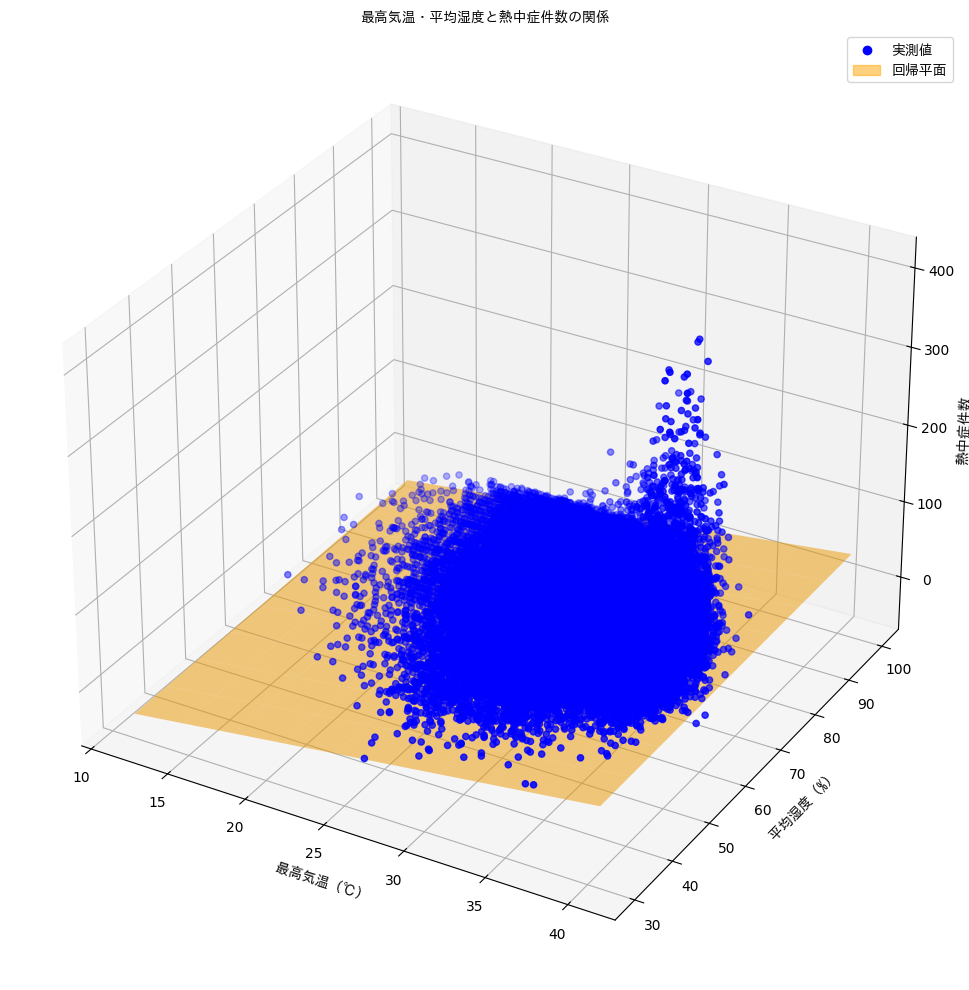

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np

jp_font = fm.FontProperties(fname=font_path)

# 説明変数
x_temp = df_clean["最高気温"]
x_humi = df_clean["平均湿度"]
y_count = df_clean["件数"]


# 回帰平面用の格子データ
temp_range = np.linspace(x_temp.min(), x_temp.max(), 10)
humi_range = np.linspace(x_humi.min(), x_humi.max(), 10)
temp_grid, humi_grid = np.meshgrid(temp_range, humi_range)
count_pred = model.predict(np.c_[temp_grid.ravel(), humi_grid.ravel()]).reshape(temp_grid.shape)

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 散布図
scatter_plot = ax.scatter(x_temp, x_humi, y_count, color='blue')

# 回帰平面
surface_plot = ax.plot_surface(temp_grid, humi_grid, count_pred, color='orange', alpha=0.5)

# ラベル
ax.set_xlabel("最高気温 (℃)", fontproperties=jp_font)
ax.set_ylabel("平均湿度 (%)", fontproperties=jp_font)
ax.set_zlabel("熱中症件数", fontproperties=jp_font)
ax.set_title("最高気温・平均湿度と熱中症件数の関係", fontproperties=jp_font)

# 凡例を手動で作成
scatter_proxy = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='実測値')
surface_proxy = mpatches.Patch(color='orange', alpha=0.5, label='回帰平面')
ax.legend(handles=[scatter_proxy, surface_proxy],prop=fontproperties)

plt.tight_layout()
plt.show()
